In [1]:
import wrds
import pandas as pd
import numpy as np
from datetime import datetime as dt
import time
import random

import yfinance as yf

In [2]:

from numpy.linalg import det, inv, eigvals

import scipy
from scipy.optimize import minimize, LinearConstraint, Bounds, basinhopping

import matplotlib.pyplot as plt

In [3]:
# Connect to WRDS
conn = wrds.Connection()

Enter your WRDS username [prith]: prithwish
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [5]:
# Define the date range
start_date = '1999-01-01'
end_date = '2008-12-31'

query_volume = f"""
SELECT a.permno, SUM(a.vol) as total_vol
FROM crsp.dsf as a
WHERE a.date BETWEEN '{start_date}' AND '{end_date}'
GROUP BY a.permno
ORDER BY total_vol DESC
"""

top10 = conn.raw_sql(query_volume)


In [6]:
query_names = f"""SELECT distinct msenames.permno, msenames.ticker, msenames.comnam
FROM crsp.msenames AS msenames
WHERE msenames.namedt > '{start_date}' AND msenames.nameendt > '{end_date}'"""

names_tickers = conn.raw_sql(query_names)

In [7]:
names_tickers

,permno,ticker,comnam
0,15033,EHIC,EHI CAR SERVICES LTD
1,17912,ACES,ALPS E T F TRUST
2,86067,None,GUARANTY BANCSHARES INC
3,53225,GHC,GRAHAM HOLDINGS CO
4,92756,PWND,POWERSHARES E T F TRUST II
...,...,...,...
20920,92442,INET,INTERNET BRANDS INC
20921,14344,NETI,ENETI INC
20922,16072,OVLC,CLAYMORE E T F TRUST 2
20923,15183,ONCE,SPARK THERAPEUTICS INC


In [8]:
len(np.unique(names_tickers['permno']))

16706

In [37]:
# Replace 'crsp' and 'dsp500list' with the schema and table name you are interested in
table_description = conn.describe_table('crsp', 'msenames')

# Print the description
print(table_description)

Approximately 113856 rows in crsp.msenames.
        name  nullable         type  \
0     permno      True      INTEGER   
1     namedt      True         DATE   
2   nameendt      True         DATE   
3      shrcd      True     SMALLINT   
4     exchcd      True     SMALLINT   
5      siccd      True      INTEGER   
6     ncusip      True   VARCHAR(8)   
7     ticker      True   VARCHAR(8)   
8     comnam      True  VARCHAR(35)   
9     shrcls      True   VARCHAR(4)   
10   tsymbol      True  VARCHAR(10)   
11     naics      True   VARCHAR(7)   
12  primexch      True   VARCHAR(1)   
13   trdstat      True   VARCHAR(1)   
14   secstat      True   VARCHAR(1)   
15    permco      True      INTEGER   
16    compno      True      INTEGER   
17    issuno      True      INTEGER   
18     hexcd      True     SMALLINT   
19    hsiccd      True      INTEGER   
20     cusip      True   VARCHAR(8)   

                                          comment  
0                                          PE

In [ ]:
# Query to get historical S&P 500 constituents
start_time = time.time()
query = """
SELECT date, permno, ret, prc, cfacpr
FROM crsp.dsf
WHERE date BETWEEN '1996-01-01' AND '2020-12-31';
"""

# Execute the query and fetch the data
stock_timess = conn.raw_sql(query)
print("--- %s seconds ---" % (time.time() - start_time))
stock_timess

In [3]:
#stock_timess.to_pickle('stock_ts_pickle.p')

stock_timess = pd.read_pickle('stock_ts_pickle.p')

In [41]:
myset = top10.iloc[405:425]
myset_dict = dict(zip(myset.permno, myset.total_vol))

In [42]:
myset

,permno,total_vol
405,50227,5.079512e+09
406,70228,5.073793e+09
407,89463,5.040785e+09
408,81126,5.037250e+09
409,68304,5.036998e+09
410,45495,5.022316e+09
411,72726,5.021883e+09
412,22103,4.988364e+09
413,86458,4.966924e+09
414,53831,4.958556e+09


In [43]:
# Define the stock permanent numbers for S&P 500 stocks (replace with actual permnos)
permnos = list(myset_dict.keys())  # Example permnos for AAPL, MSFT, WMT respectively
# Initialize an empty DataFrame to store results
daily_returns = pd.DataFrame()
# Loop through each stock's permno and fetch data
for permno in permnos:
    stock_data= stock_timess[stock_timess['permno']==permno].copy()
    stock_data.rename(columns={'ret': str(permno)}, inplace=True)
    #stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data.set_index('date', inplace=True)
    stock_data.index = pd.to_datetime(stock_data.index).strftime('%Y-%m-%d')
    # Concatenate daily returns for each stock to the main DataFrame
    daily_returns = pd.concat([daily_returns, stock_data[str(permno)]], axis=1, sort=True)

In [45]:
daily_returns

,50227,70228,89463,81126,68304,45495,72726,22103,86458,53831,88845,86783,18382,83976,89031,77292,81138,82775,81776,80303
1996-01-02,-0.006410,-0.005435,NaN,0.032544,0.018868,0.012987,-0.002778,-0.004587,NaN,0.014389,NaN,NaN,0.015306,NaN,NaN,-0.016216,-0.060703,0.002584,-0.003831,0.007299
1996-01-03,-0.004839,0.005464,NaN,-0.060172,0.024691,0.000000,-0.005571,-0.009217,NaN,0.000000,NaN,NaN,0.002010,NaN,NaN,0.060440,-0.061225,-0.002577,-0.030769,0.007246
1996-01-04,0.000000,-0.021739,NaN,-0.027439,-0.030121,-0.012821,-0.014006,-0.003101,NaN,-0.024823,NaN,NaN,-0.026078,NaN,NaN,-0.072539,0.057971,0.010336,-0.047619,-0.003597
1996-01-05,-0.003241,0.011111,NaN,0.012539,0.000000,-0.012987,-0.017046,0.000000,NaN,-0.010909,NaN,NaN,0.019568,NaN,NaN,-0.044693,0.047945,-0.002558,0.016667,-0.003610
1996-01-08,0.001626,0.005495,NaN,-0.003096,-0.012422,0.000000,0.008671,0.009331,NaN,-0.003676,NaN,NaN,0.002020,NaN,NaN,0.087719,-0.006536,0.023077,0.040984,0.010870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,NaN,0.011979,NaN,NaN,NaN,NaN,0.002794,-0.000500,0.007075,NaN,NaN,-0.005950,NaN,-0.020955,-0.008192,0.026820,NaN,0.002900,NaN,NaN
2020-12-28,NaN,-0.010302,NaN,NaN,NaN,NaN,0.004737,-0.001375,0.004411,NaN,NaN,0.023736,NaN,0.015928,-0.042753,0.011194,NaN,-0.004338,NaN,NaN
2020-12-29,NaN,-0.005094,NaN,NaN,NaN,NaN,-0.002496,-0.007888,-0.000163,NaN,NaN,0.022209,NaN,-0.005390,-0.014621,-0.003690,NaN,-0.013901,NaN,NaN
2020-12-30,NaN,-0.003562,NaN,NaN,NaN,NaN,0.006672,0.007320,0.005043,NaN,NaN,0.009088,NaN,0.020197,0.004460,-0.085185,NaN,0.008626,NaN,NaN


In [46]:
# Disconnect from WRDS
conn.close()

## YFinance Data Fetch

In [4]:
# Yfinance method to find the most traded stocks
# List of stock tickers
stocks =["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "BRK-B", "JNJ",
"WMT", "V", "PG", "NVDA", "JPM", "UNH", "HD", "MA", "DIS", "PFE", "VZ", 
"INTC", "CMCSA", "T", "KO", "MRK", "PEP", "ABT", "CVX", "ORCL", "CSCO", 
"NFLX", "XOM", "IBM", "NKE", "CRM", "ADBE", "AVGO", "GS", "QCOM", "BA", 
"PYPL", "TXN", "AXP", "AMD", "C", "MS", "CAT", "HON", "SBUX", "COST", "MCD"]  # Add more as needed

# Start and end dates
start_date = '1999-01-01'
end_date = '2007-12-31'

# DataFrame to store total volumes
total_volumes = pd.DataFrame()

for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)
    total_volume = data['Volume'].sum()
    temp_df = pd.DataFrame({'Stock': [stock], 'Total Volume': [total_volume]})
    # Using concat to add the new row to the total_volumes DataFrame
    total_volumes = pd.concat([total_volumes, temp_df], ignore_index=True)

# Sorting by total volume
total_volumes.sort_values(by='Total Volume', ascending=False, inplace=True)

print(total_volumes)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['META']: YFChartError("%ticker%: Data doesn't exist for startDate = 915166800, endDate = 1199077200")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFChartError("%ticker%: Data doesn't exist for startDate = 915166800, endDate = 1199077200")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['V']: YFChartError("%ticker%: Data doesn't 

    Stock  Total Volume
11   NVDA  1.646542e+12
0    AAPL  1.266665e+12
2    AMZN  4.233434e+11
3   GOOGL  2.813720e+11
1    MSFT  1.559454e+11
19   INTC  1.338441e+11
28   CSCO  1.336492e+11
27   ORCL  1.055490e+11
8     WMT  7.065891e+10
37   QCOM  5.842869e+10
17    PFE  5.127119e+10
20  CMCSA  4.048261e+10
47   SBUX  3.900458e+10
30    XOM  3.256529e+10
21      T  3.204521e+10
40    TXN  2.833350e+10
32    NKE  2.701935e+10
42    AMD  2.666661e+10
22     KO  2.627695e+10
12    JPM  2.327953e+10
14     HD  2.188924e+10
25    ABT  2.111959e+10
23    MRK  1.910180e+10
29   NFLX  1.896069e+10
18     VZ  1.854043e+10
16    DIS  1.842393e+10
7     JNJ  1.812830e+10
13    UNH  1.777200e+10
31    IBM  1.763844e+10
10     PG  1.730653e+10
34   ADBE  1.641188e+10
26    CVX  1.421534e+10
41    AXP  1.318558e+10
49    MCD  1.293251e+10
15     MA  1.268743e+10
44     MS  1.230551e+10
45    CAT  1.050057e+10
24    PEP  9.996805e+09
48   COST  9.911146e+09
46    HON  9.395036e+09
36     GS  8.957

In [5]:
list(total_volumes.iloc[0:10]['Stock'])

['NVDA',
 'AAPL',
 'AMZN',
 'GOOGL',
 'MSFT',
 'INTC',
 'CSCO',
 'ORCL',
 'WMT',
 'QCOM']

In [6]:
# Define the stock tickers and the time period
tickers = list(total_volumes.iloc[0:10]['Stock'])
#tickers = ["BAC", "MSFT", "AMZN", "WMT", "CVX", "PFE", "JNJ", "PG", "KO", "PEP",]  # Replace with S&P 500 tickers

# Download the stock price data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']


[*********************100%%**********************]  10 of 10 completed


In [7]:
#training and testing dates

training_period_start = "1999-01-01"
training_period_end = "2007-12-31"
test_period_end = "2008-12-31"


In [8]:
daily_returns = data.pct_change(fill_method='ffill')

C:\Users\prith\AppData\Local\Temp\ipykernel_19880\4103529606.py:1: FutureWarning: The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change(fill_method='ffill')


In [9]:
daily_returns

Ticker,AAPL,AMZN,CSCO,GOOGL,INTC,MSFT,NVDA,ORCL,QCOM,WMT
Date,,,,,,,,,,
1999-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,0.050000,0.052298,0.017049,NaN,0.020176,0.039007,NaN,0.030523,0.030440,0.007752
1999-01-06,-0.036075,0.108434,0.029013,NaN,0.050710,0.032424,NaN,0.046544,0.040481,0.016923
1999-01-07,0.077845,0.151268,0.038847,NaN,-0.001931,-0.004959,NaN,-0.016172,0.008412,0.018154
1999-01-08,0.000000,0.008655,0.029554,NaN,0.003385,-0.004153,NaN,0.013698,0.005214,-0.007429
...,...,...,...,...,...,...,...,...,...,...
2007-12-21,0.035789,0.007507,0.011315,0.010149,0.020826,0.015202,-0.000284,0.027602,0.021472,0.007524
2007-12-24,0.025218,-0.002739,0.004196,0.005799,0.012982,0.014421,0.017634,0.002202,0.008759,0.010993
2007-12-26,0.000755,0.020218,-0.011838,0.014428,0.005126,0.000820,0.013415,0.010545,-0.000744,-0.007386


In [10]:
# Calculate the mean and covariance of daily returns for the first 12 years
training_data = daily_returns.loc[training_period_start:training_period_end]

mu = np.array(training_data.mean())
Sigma = np.array(training_data.cov())
gamma = 1

In [11]:
Sigma.shape

(10, 10)

In [12]:
## Nominal Portfolio
n = daily_returns.shape[1]

In [13]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
ones_for_sum = np.ones((1, n))
linear_constraint = LinearConstraint(ones_for_sum, [1], [1])

initial_weights = np.ones(n) / n


def objective_nom(a, Sigma): #calculate portfolio risk
    return (gamma/2)*np.dot(a, np.dot(a, Sigma))- np.dot(a, mu)

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(objective_nom, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds, args = (Sigma))
a_hat = res.x
print("Optimal Weights:", a_hat)

# The corresponding relative entropy with this is zero, because we haven't changed the distribution
E_Va = objective_nom(a_hat, Sigma)

Optimal Weights: [2.51151257e-03 8.90934341e-04 6.76771009e-04 8.70730282e-01
 6.25154091e-04 6.49039324e-04 1.19974078e-01 9.64157369e-04
 2.08325495e-03 8.94816221e-04]


In [162]:
## Worst Case Portfolio

In [175]:
I = np.eye(n)

#speciific case for analysis
theta_ = 15

def objective_a_oftheta(a, theta):
    term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma))
    return (1/theta)*(term1) + a.T @ mu

def positive_definite_constraint(a, theta):
    eigenvalues = eigvals(inv(Sigma) - theta * gamma * np.outer(a,a) )
    return np.min(eigenvalues) - 1e-10  # Ensure all eigenvalues are slightly greater than zero


In [176]:
# monte-carlo sampling optimization, because the above one does not works
n_points = 1000
points_on_hyperplane = np.zeros((n_points, 10))

for j in range(n_points):
    random_numbers = np.random.rand(10)
    # Normalize the numbers so their sum is 10
    normalized_numbers = random_numbers / random_numbers.sum() 

    points_on_hyperplane[j] = normalized_numbers

In [177]:
min_eig_vals = np.apply_along_axis(positive_definite_constraint, axis=1, arr=points_on_hyperplane, theta = theta_)
first_positive = np.argmax(min_eig_vals > 0)
a0 = points_on_hyperplane[first_positive]

In [178]:
# Initial guess for 'a'
#a0 = points_on_hyperplane[1]

# Define constraints in the format required by 'minimize'
constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)},
    linear_constraint
] 

# Perform the optimization
result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=bounds, args = (theta_))

# Check if the optimization was successful
if result.success:
    a_star = result.x
    print("Optimized a:", a_star)
    print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
else:
    print("Optimization failed:", result.message)

Optimized a: [0.         0.         0.23426696 0.         0.20068037 0.23427285
 0.         0.         0.         0.33077982]
 Minimum adjective reached at 0.06721311537460005 Not portfolio objective!


In [179]:
# Define constraints in the format required by 'minimize'
constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)},
    linear_constraint
] 

# Setting up the minimizer_kwargs for basinhopping
minimizer_kwargs = {"method": 'SLSQP',
                    "bounds": bounds,
                    "constraints": constraints,
                    "args": (theta_,)}

# Perform the basinhopping optimization
result = basinhopping(objective_a_oftheta, a0, minimizer_kwargs=minimizer_kwargs)

print("Global minimum: x = {}, objective = {}".format(result.x, result.fun))

Global minimum: x = [1.39199061e-17 4.16333634e-17 3.00085456e-02 2.70575731e-16
 5.29251895e-02 2.98237541e-01 3.09438453e-18 4.31129026e-18
 2.76070962e-18 6.18828724e-01], objective = 0.06711003736738236


In [180]:
#computaion of entropy, risk_measuremennt
#mvo = mean variance objective
Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))

entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2

RPs_nominal = objective_nom(a_star, Sigma)
NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)

risk_meas2 = -np.dot(a_star, mu) + (gamma/2)*np.dot(a_star, np.dot(a_star, Sigma_tilda))
# Both of them are the same

In [181]:
entropy

6.546808676113989e-06

In [182]:
#Scipy based optimization

In [183]:
# monte-carlo sampling optimization, because the above one does not works
n_points = 1000
points_on_hyperplane = np.zeros((n_points, 10))

for j in range(n_points):
    random_numbers = np.random.rand(10)
    # Normalize the numbers so their sum is 10
    normalized_numbers = random_numbers / random_numbers.sum() 

    points_on_hyperplane[j] = normalized_numbers

In [187]:
results_ = {}
thetas = (np.exp(np.linspace(0, 10)) - 1)[1:]
for theta in thetas:
    
    min_eig_vals = np.apply_along_axis(positive_definite_constraint, axis=1, arr=points_on_hyperplane, theta = theta)
    first_positive = np.argmax(min_eig_vals > 0)
    a0 = points_on_hyperplane[first_positive]

    constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta,)},
    linear_constraint
    ]
    
    # Setting up the minimizer_kwargs for basinhopping
    minimizer_kwargs = {"method": 'SLSQP',
                        "bounds": bounds,
                        "constraints": constraints,
                        "args": (theta,)}
    
    # Perform the basinhopping optimization
    result = basinhopping(objective_a_oftheta, a0, minimizer_kwargs=minimizer_kwargs)

    # Check if the optimization was successful
    if result.success:
        a_star = result.x
        print("Optimized a:", a_star)
        print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk-measurement
    Sigma_tilda = inv(inv(Sigma) - theta * gamma * np.outer(a_star, a_star))
    
    entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2
    
    RPs_nominal = objective_nom(a_star, Sigma)
                    
    NP_worstcase = objective_nom(a_hat, Sigma_tilda)
    RPs_worstcase = objective_nom(a_star, Sigma_tilda)
    
    results_[theta] = (entropy, RPs_nominal, NP_worstcase, RPs_worstcase)

Optimized a: [0.00000000e+00 0.00000000e+00 4.94597203e-02 0.00000000e+00
 6.15771637e-02 2.94635580e-01 2.41238438e-18 3.68608099e-03
 6.93889390e-18 5.90641455e-01]
 Minimum adjective reached at 4.417446669036572 Not portfolio objective!
Optimized a: [8.32667268e-17 4.16333634e-17 0.00000000e+00 1.38777878e-16
 0.00000000e+00 4.69219443e-01 0.00000000e+00 0.00000000e+00
 4.16333634e-17 5.30780557e-01]
 Minimum adjective reached at 1.9843563204301096 Not portfolio objective!
Optimized a: [0.00000000e+00 4.34271623e-19 1.12833709e-02 0.00000000e+00
 2.90830659e-02 3.00175752e-01 0.00000000e+00 5.44451433e-04
 1.73983224e-19 6.58913360e-01]
 Minimum adjective reached at 1.18447498844494 Not portfolio objective!
Optimized a: [0.00000000e+00 0.00000000e+00 2.83009192e-03 7.28658841e-19
 4.76849934e-03 3.70451360e-01 0.00000000e+00 8.80463409e-20
 0.00000000e+00 6.21950049e-01]
 Minimum adjective reached at 0.7927170009086006 Not portfolio objective!
Optimized a: [0.00000000e+00 4.56112337

C:\Users\prith\AppData\Local\Temp\ipykernel_12048\19668138.py:7: RuntimeWarning: invalid value encountered in sqrt
  term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma))


Optimized a: [0.00000000e+00 1.14613218e-17 1.65708173e-02 0.00000000e+00
 2.24954818e-02 2.99238222e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.61695479e-01]
 Minimum adjective reached at 0.0079588630529621 Not portfolio objective!
Optimized a: [1.59594560e-16 0.00000000e+00 4.47050868e-02 0.00000000e+00
 5.34666284e-02 2.77638702e-01 3.28730099e-16 0.00000000e+00
 0.00000000e+00 6.24189583e-01]
 Minimum adjective reached at 0.006572393846731445 Not portfolio objective!
Optimized a: [1.31656255e-17 3.65747436e-18 0.00000000e+00 3.63861723e-19
 1.11022302e-16 3.19216333e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.80783667e-01]
 Minimum adjective reached at 0.005424066191023341 Not portfolio objective!
Optimized a: [0.00000000e+00 1.37915029e-03 1.04083409e-16 0.00000000e+00
 0.00000000e+00 2.33699273e-01 2.77555756e-17 3.46944695e-17
 2.08166817e-17 7.64921577e-01]
 Minimum adjective reached at 0.004506406641739649 Not portfolio objective!
Optimized a: [1.75541673e-17 2

C:\Users\prith\AppData\Local\Temp\ipykernel_12048\1289964423.py:34: RuntimeWarning: invalid value encountered in log
  entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2


Optimization failed: ['requested number of basinhopping iterations completed successfully']
Optimization failed: ['requested number of basinhopping iterations completed successfully']
Optimization failed: ['requested number of basinhopping iterations completed successfully']
Optimization failed: ['requested number of basinhopping iterations completed successfully']
Optimization failed: ['requested number of basinhopping iterations completed successfully']
Optimization failed: ['requested number of basinhopping iterations completed successfully']
Optimization failed: ['requested number of basinhopping iterations completed successfully']
Optimization failed: ['requested number of basinhopping iterations completed successfully']


In [188]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results_.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'RPs_nominal', 'NPs_worstcase', 'RPs_worstcase'])

In [189]:
df_wc

,Theta,Entropy,RPs_nominal,NPs_worstcase,RPs_worstcase
0,0.226398,8.897671e-10,-0.000188,-0.002307,-0.000188
1,0.504053,4.552555e-09,-0.000169,-0.002307,-0.000169
2,0.844568,1.253311e-08,-0.000172,-0.002307,-0.000172
3,1.262175,2.782738e-08,-0.000169,-0.002307,-0.000169
4,1.774327,5.462894e-08,-0.000173,-0.002307,-0.000173
5,2.402430,1.023084e-07,-0.000172,-0.002307,-0.000171
6,3.172734,1.804821e-07,-0.000169,-0.002307,-0.000169
7,4.117434,2.933523e-07,-0.000174,-0.002307,-0.000173
8,5.276012,4.814716e-07,-0.000177,-0.002307,-0.000177
9,6.696890,7.786307e-07,-0.000174,-0.002307,-0.000173


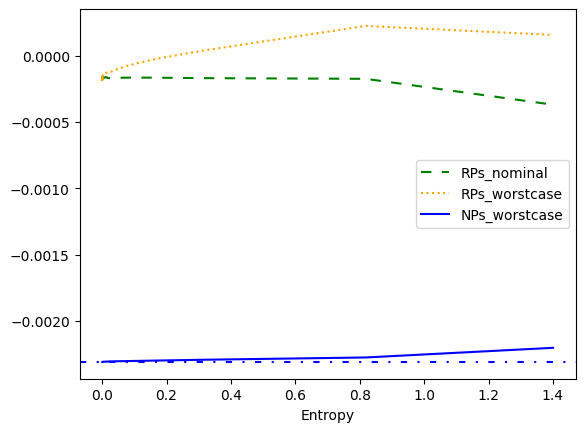

In [190]:
ax = plt.gca()
df_wc.plot(ax = ax, x='Entropy',y='RPs_nominal', linestyle=(0, (5, 5)), linewidth=1.5, color='green')
ax.axhline(y = E_Va, color = 'b', linestyle = (0, (3, 5, 1, 5)))
df_wc.plot(ax = ax, x='Entropy',y='RPs_worstcase', linestyle='dotted', linewidth=1.5, color='orange')
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
plt.show()